In [27]:
import sys
from pathlib import Path
import importlib
import math

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
from scipy.stats import norm
import seaborn as sns
from tqdm import tqdm


sys.path.insert(0, str(Path("../..").resolve()))
from curves import CubicSpline

# Local modules
#import gm_utils
#importlib.reload(gm_utils)  
#from gm_utils import visualize_density, sample, geodesic, energy
#from curves import CubicSpline

# Matplotlib settings
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

# 1D-Experiments for different noise schedules
- <span style="color:green">  Main change: compute_vector_field(x, t) to work for general noise schedules using the formulas from the paper</span>


In [12]:
def gaussian_mixture_density(x, t):
    """Analytical implementation of the marginal log-density at time t"""
    alpha_t, sigma_t = alpha_sigma(t)
    means_t = alpha_t[:, None] * original_means[None, :]

    variances_t = sigma_t[:, None]**2 + alpha_t[:, None]**2 * original_variance
    log_probs = torch.log(weights[None, :]) - 0.5 * (torch.log(2 * torch.pi * variances_t) + (x[:, None] - means_t)**2 / variances_t)
    log_p_t = torch.logsumexp(log_probs, dim=1)
    return log_p_t


def compute_vector_field(x, t):
    """
    PF-ODE vector field for any alpha_sigma(t)
    Outputs dt and dx shaped to match the previous working version.
    x: (B, D)
    t: (B,)
    """
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)

    alpha_t, sigma_t = alpha_sigma(t)

    log_alpha = torch.log(alpha_t)
    f_t = torch.autograd.grad(log_alpha.sum(), t, create_graph=True)[0]

    lambda_t = torch.log(alpha_t**2 / sigma_t**2)
    dlambda_dt = torch.autograd.grad(lambda_t.sum(), t, create_graph=True)[0]
    g2_t = - sigma_t**2 * dlambda_dt

    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]

    dx = f_t * x - 0.5 * g2_t * grad_log_p_t
    dt = -torch.ones_like(dx)

    dx = dx.view(-1)
    dt = dt.view(-1)
    return dt.detach().cpu().numpy(), dx.detach().cpu().numpy()


def sample(x, n_steps, t_start=1, t_end=0.9):
    """PF-ODE sampling"""
    t = t_start * torch.ones_like(x)
    dt_val = (t_start - t_end) / n_steps
    all_x = [x.detach().numpy()]
    all_t = [t.detach().numpy()]
    for i in range(n_steps):
        dt, dx = compute_vector_field(x, t)
        dt, dx = torch.from_numpy(dt), torch.from_numpy(dx)
        x = x + dt * dx * dt_val
        t = t + dt * dt_val
        all_x.append(x.detach().numpy())
        all_t.append(t.detach().numpy())
    return np.array(all_t), np.array(all_x)



def eds(t, x):
    """Implementation of the denoising mean, or Expected Denoised Sample (EDS) - based on Tweedie formula using the score function - Eq61 in the paper"""
    assert t.shape == x.shape
    assert t.ndim == 1
    alpha_t, sigma_t = alpha_sigma(t)    
    x.requires_grad_(True)
    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]
    res = (x + sigma_t ** 2 * grad_log_p_t)
    res = res / alpha_t
    return res

def mu(theta):
    """
    Implementation of the expectation parameter - Eq 22 in the paper. Since our data distribution is 1D, the spacetime is 2D
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    mu_t : torch.Tensor
        `time` component of the expectation parameter - tensor or shape (N,)
    mu_x : torch.Tensor
        `space` component of the expectation parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    x.requires_grad_(True)
    f = eds(t, x)
    div = torch.autograd.grad(f.sum(), x, create_graph=True)[0] # In 1D the divergence is just the derivative
    mu_t, mu_x = sigma_t ** 2 / alpha_t * div + f ** 2, f
    return mu_t, mu_x

def eta(theta):
    """
    Implementation of the natural parameter - Eq 18 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    eta_t : torch.Tensor
        `time` component of the natural parameter - tensor or shape (N,)
    eta_x : torch.Tensor
        `space` component of the natural parameter - tensor of shape (N,)
    """
    t, x = theta[:, 0], theta[:, 1]
    alpha_t, sigma_t = alpha_sigma(t)
    return -0.5 * alpha_t**2/sigma_t**2, alpha_t/sigma_t**2 * x



def energy(theta):
    """
    Implementation of the energy of a discretized curve - Eq 23 in the paper.
    Parameters
    ----------
    theta: torch.Tensor
        a batch of spacetime points of shape (N, 2), where the first column is the `time` component, and the second is the `space` component
    Returns
    ----------
    energy : torch.Tensor
        Energy represented as tensor of shape (,)
    """
    mu_t, mu_x = mu(theta)
    eta_t, eta_x = eta(theta)
    energies = (mu_t[1:] - mu_t[:-1]) * (eta_t[1:] - eta_t[:-1]) + (mu_x[1:] - mu_x[:-1]) * (eta_x[1:] - eta_x[:-1])
    return energies.sum()

def geodesic(theta1, theta2, n_opt_steps, num_intermediate_points, num_nodes=20):
    """
    Implementation of approximate geodesic, parametrizes the curve as a CubicSpline and minimizes its energy w.r.t. curve's parameters using Adam optimizer
    Parameters
    ----------
    theta1: torch.Tensor
        First endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    theta2: torch.Tensor
        Second endpoint of the curve, represented as a point in spacetime, i.e. (2,) tensor
    n_opt_steps : int
        Number of optimization steps
    num_intermediate_points : int
        Number of points to discretize the curve into (in the paper: `N`)
    num_nodes : int
        Parameter of the CubicSpline. The higher the number of nodes, the more flexible/expressive the curve
    """
    curve = CubicSpline(begin=theta1, end=theta2, num_nodes=num_nodes)
    optimizer = torch.optim.Adam(curve.parameters(), lr=1e-1)
    t_tensor = torch.linspace(0, 1, num_intermediate_points).unsqueeze(0)
    for step_id in tqdm(range(n_opt_steps)):
        optimizer.zero_grad()
        theta = curve(t_tensor)[0]
        loss = energy(theta)
        loss.backward()
        optimizer.step()
    return curve(t_tensor)[0].detach().numpy()



def plot_ode_geodesics(points):
    t_min = 0.1
    for i, x in enumerate(points):
        pf_ode_sample = sample(x, 512, t_start=0.99, t_end=t_min)
        pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
        print('Energy of pf ode trajectory:', energy(pf_ode_theta).item(), end=' ')
        theta1 = pf_ode_theta[0]
        theta2 = pf_ode_theta[-1]
        print('theta1', theta1)
        print('theta2', theta2)
        shortest_path12 = geodesic(theta1, theta2, n_opt_steps=1000, num_intermediate_points=1000, num_nodes=800)
        print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())
        if i == 0:
            label_pf = 'PF-ODE trajectory'
            label_g = 'Spacetime Geodesic'
        else:
            label_pf = None
            label_g = None
        ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3', label=label_pf)
        ax.plot(shortest_path12[:, 0], shortest_path12[:, 1], color='C3', linestyle='--', label=label_g)


 
def visualize_density(ax):
    """Estimates the marginal log-densities and visualizes it as background for the spacetime - used for both Fig1, and Fig5"""
    n_time_points = 50
    n_space_points = 200

    t_vals = torch.linspace(0, 1, n_time_points)
    x_vals = torch.linspace(-1.5, 1.5, n_space_points)
    T, X = np.meshgrid(t_vals.numpy(), x_vals.numpy())
    
    T_flat = T.flatten()
    X_flat = X.flatten()
    densities = gaussian_mixture_density(torch.from_numpy(X_flat), torch.from_numpy(T_flat)).reshape(X.shape).detach()
        

    ax.contourf(T, X, (densities).reshape(X.shape), levels=25, cmap='viridis', alpha=0.8)

In [ ]:
'''
------------------------------
Noise schedules to choose from
------------------------------
'''

def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def alpha_sigma(t, T=1.0, kappa=0.3, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t

def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t


def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t


def alpha_sigma(t, T=1.0):
    """
    Forward process parameters for a Variance-Preserving (VP) SDE
    with a *linear-in-noise-variance* schedule..
    """
    sigma2_t = t / T
    sigma_t = torch.sqrt(sigma2_t)
    alpha_t = torch.sqrt(1.0 - sigma2_t)

    return alpha_t, sigma_t


def alpha_sigma(t, s=0.008):
    """
    Cosine noise schedule from 'Improved Denoising Diffusion Probabilistic Models'.

    Args:
        t: torch.Tensor with values in [0, 1]
        s: small offset to avoid singularities

    Returns:
        alpha_t, sigma_t : tensors of same shape as t
    """
    t = torch.clamp(t, 0.0, 1.0)

    # f(t) = cos^2(((t + s)/(1 + s)) * pi/2)
    f_t = torch.cos(((t + s) / (1 + s)) * math.pi / 2) ** 2

    # use math.cos or a tensor constant to avoid the float→tensor error
    f_0 = math.cos((s / (1 + s)) * math.pi / 2) ** 2

    alpha_t_sq = f_t / f_0
    alpha_t = torch.sqrt(alpha_t_sq)
    sigma_t = torch.sqrt(1.0 - alpha_t_sq)

    return alpha_t, sigma_t


Energy of pf ode trajectory: 0.07233205437660217 theta1 tensor([0.9900, 1.0000])
theta2 tensor([0.1000, 1.0061])


100%|██████████| 1000/1000 [00:11<00:00, 84.84it/s]


Energy of a geodesic: 0.0208571944385767
Energy of pf ode trajectory: 0.0874505341053009 theta1 tensor([0.9900, 0.2000])
theta2 tensor([0.1000, 0.0644])


100%|██████████| 1000/1000 [00:12<00:00, 79.92it/s]


Energy of a geodesic: 0.021497324109077454
Energy of pf ode trajectory: 0.07233206182718277 theta1 tensor([ 0.9900, -1.0000])
theta2 tensor([ 0.1000, -1.0061])


100%|██████████| 1000/1000 [00:14<00:00, 69.68it/s]


Energy of a geodesic: 0.020857643336057663


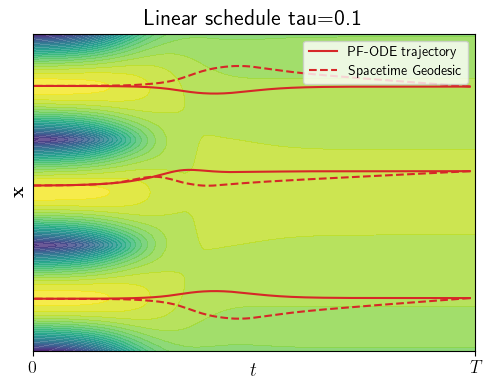

In [14]:
'''
---------------
Hyperparameters
---------------
'''
LAMBDA_MIN, LAMBDA_MAX = -10, 10  
num_discretization_points = 10
num_optimization_steps = 200


original_means = torch.tensor([-1,0,1], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.01, dtype=torch.float32) #0.4
weights = torch.tensor([1/3,1/3,1/3], dtype=torch.float32)


'''
---------------
Noise schedule
---------------
'''

def alpha_sigma(t, T=1.0, kappa=0.9, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t).
    """
    tau_t = tau(t, kappa=kappa, d=d)
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t

def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t


fig, ax = plt.subplots(figsize=(5, 4))
t_min = 0.1
visualize_density(ax)
plot_ode_geodesics(torch.tensor([[1.], [0.2], [-1]]))
ax.legend()
ax.set_xlim((t_min, 1))
ax.set_xticks([t_min, 1], [r'$0$', r'$T$'], fontsize=13)
ax.set_yticks([])
ax.set_xlabel(r'$t$', fontsize=14, labelpad=-10)
ax.set_ylabel(r'$\mathbf{x}$', fontsize=14)
ax.set_title('Linear schedule tau=0.1', fontsize=16)
plt.tight_layout()
plt.show()



<span style="color:red"> By changing tau, we can control how quickly the noise schedule destroys information. We can find a noise scheudle were the relative distance between points is not preserved (like in the image below)

<img src="image.png" alt="alt text" width="500">


100%|██████████| 200/200 [00:03<00:00, 63.34it/s]


Energy of a geodesic: 3.234818935394287


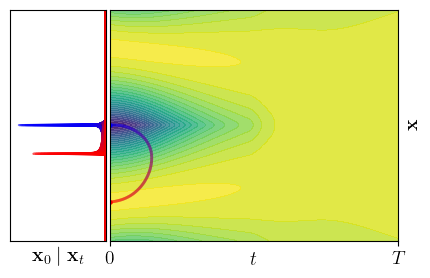

In [19]:
'''
---------------
Hyperparameters
---------------
'''


LAMBDA_MIN, LAMBDA_MAX = -10, 10  
num_discretization_points = 1000
num_optimization_steps = 200

original_means = torch.tensor([-1,1], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.01, dtype=torch.float32) #0.4
weights = torch.tensor([1/2,1/2], dtype=torch.float32)

theta1 = torch.tensor([0.001, 0.]) #(theta=(t, x))
theta2 = torch.tensor([0.001, -1.])

'''
---------------------
Choose noise schedule
---------------------
'''

def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def alpha_sigma(t, T=1.0, kappa=0.2, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t). kappa controls how quickly the information gets destroyed. 
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t



shortest_path12 = geodesic(theta1, theta2, num_optimization_steps, num_discretization_points, num_nodes=800)
print('Energy of a geodesic:', energy(torch.from_numpy(shortest_path12)).item())

def get_means_and_variances(t, x):
    """
    When the data distribution p0 is a Gaussian mixture, then for every (t, xt), the `denoising distribution` (Eq 15 in the paper) is also a Gaussian Mixture. This function calculates the means and std of the denoising distribution in our Gaussian Mixture toy example. This function is used only to visualize the transition of densities in Figure 1.
    """
    alpha, sigma = alpha_sigma(t)
    snr = alpha**2 / sigma**2
    variance_inv = 1 / original_variance + snr
    variance = 1 / variance_inv
    means = original_means/original_variance + alpha/sigma ** 2 * x
    return (means * variance).numpy(), variance.numpy()


def visualize_density_w_geodesic(ax):
    visualize_density(ax)
    ax.set_xlabel(r"$t$", labelpad=-12, fontsize=14)
    ax.set_yticks([])
    ax.set_xticks([0, 1], [r'$0$', r'$T$'], fontsize=14)
    ax.scatter(*theta1.numpy(), color='blue', s=5)
    ax.scatter(*theta2.numpy(), color='red', s=5)

    points = shortest_path12

    segments = np.concatenate([points[:-1, None], points[1:, None]], axis=1)
    norm = plt.Normalize(0, len(points) - 1)
    cmap = LinearSegmentedColormap.from_list('blue_red_gradient', ['blue', 'red'], N=len(points))

    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(np.arange(len(points)))
    lc.set_linewidth(2)

    ax.add_collection(lc)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_ylabel(r"$\mathbf{x}$", fontsize=14)
fig, (ax2, ax1) = plt.subplots(ncols=2, figsize=(5, 3), width_ratios=[1, 3])

visualize_density_w_geodesic(ax1)

num_plots = num_discretization_points

cmap = LinearSegmentedColormap.from_list('blue_red_gradient', ['blue', 'red'], N=num_plots)
colors = [cmap(i / (num_plots - 1)) for i in range(num_plots)]

indices = np.round(np.linspace(0, num_plots - 1, num_plots)).astype(np.int32)
x = np.linspace(-6, 8, 1000)
max_pdf = 0

for idx in range(num_plots):
    theta = torch.from_numpy(shortest_path12[idx])
    mean, var = get_means_and_variances(theta[0], theta[1])
    pdf = np.zeros_like(x)
    for mean_i, weight_i in zip(mean, weights):
        pdf += weight_i.item() * norm.pdf(x, loc=mean_i, scale=var ** 0.5)
    pdf = pdf
    max_pdf = max(max_pdf, np.max(pdf))
    if idx == 0 or idx == num_plots - 1:
        alpha = 1
    else:
        alpha = 0.3
    ax2.plot(-pdf, x, color=colors[idx], alpha=alpha)
    ax2.set_ylim((-4, 4))
    ax2.set_xlim((-1.1 * max_pdf, 0))

ax2.set_xlabel(r'$\mathbf{x}_0 \mid \mathbf{x}_t$', fontsize=14)
ax2.set_xticks([])
ax2.set_yticks([])
plt.subplots_adjust(wspace=0.02)



# Curvature and Phase Transition

- Study the curvature of 2D manifolds using Christoffel symbols
- Need to compute the metric again because the tensor needs to be differentiable

In [20]:
def metric_tensor_differentiable(theta):
    """
    theta : torch.Tensor
        Shape (N, 2), each row = (t, x_t)
    
    Returns:
    --------
    I : torch.Tensor
        Shape (N, 2, 2), metric tensor at each spacetime point
    """
    theta = theta.clone().detach().requires_grad_(True)
    N = theta.shape[0]

    eta_t, eta_x = eta(theta)
    mu_t, mu_x = mu(theta)

    eta_vec = torch.stack([eta_t, eta_x], dim=1)  
    mu_vec = torch.stack([mu_t, mu_x], dim=1)     #

    I_batch = torch.zeros((N, 2, 2), dtype=theta.dtype, device=theta.device)

    for n in range(N):
        # Compute Jacobians J_eta and J_mu
        J_eta = torch.zeros((2, 2), dtype=theta.dtype, device=theta.device)
        J_mu = torch.zeros((2, 2), dtype=theta.dtype, device=theta.device)

        for k in range(2):
            grad_eta_k = torch.autograd.grad(
                eta_vec[n, k], theta, retain_graph=True, create_graph=True
            )[0][n]  # gradient w.r.t. θ for η_k
            grad_mu_k = torch.autograd.grad(
                mu_vec[n, k], theta, retain_graph=True, create_graph=True
            )[0][n]  # gradient w.r.t. θ for μ_k

            J_eta[k, :] = grad_eta_k
            J_mu[k, :] = grad_mu_k

        I_batch[n] = J_eta.T @ J_mu

    return I_batch, theta 

def compute_sectional_curvature(theta):
    """
    theta : torch.Tensor
        Shape (N, 2), coordinates (t, x_t)
    """

    g, theta_diff = metric_tensor_differentiable(theta)
    N = g.shape[0]
    g_inv = torch.inverse(g)  

    christoffel = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)
    g_derivs = torch.zeros((N, 2, 2, 2), dtype=theta.dtype, device=theta.device)

    #Compute all the derivatives of the metric
    for n in range(N):
        for i in range(2):
            for j in range(2):
                
                grad_outputs = torch.zeros_like(g[n, i, j])
                grad_outputs = grad_outputs + 1.0

                grad_g_ij = torch.autograd.grad(
                    g[n, i, j], theta_diff,
                    grad_outputs=grad_outputs,
                    retain_graph=True,
                    create_graph=True,
                    only_inputs=True
                )[0][n]  

                g_derivs[n, i, j, :] = grad_g_ij

    # Compute Christoffel symbols: Γ^k_ij 
    for n in range(N):
        for k in range(2):
            for i in range(2):
                for j in range(2):
                    sum_term = 0.0
                    for l in range(2):
                        bracket_term = (g_derivs[n, i, l, j] +    
                                       g_derivs[n, j, l, i] -     
                                       g_derivs[n, i, j, l])      
                        sum_term += g_inv[n, k, l] * bracket_term

                    christoffel[n, k, i, j] = 0.5 * sum_term

    # Compute Riemann tensor component R^1_212 (for 2D this is enough)

    R_1212 = torch.zeros(N, dtype=theta.dtype, device=theta.device)

    for n in range(N):
        # i, j, k, l = 0, 1, 0, 1  
        i, j, k, l = 0, 1, 0, 1

        if christoffel[n, i, j, l].requires_grad:
            dchrist_jl_k = torch.autograd.grad(
                christoffel[n, i, j, l], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, l]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, k]
        else:
            dchrist_jl_k = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        if christoffel[n, i, j, k].requires_grad:
            dchrist_jk_l = torch.autograd.grad(
                christoffel[n, i, j, k], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i, j, k]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, l]
        else:
            dchrist_jk_l = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        
        quad1 = sum(christoffel[n, i, m, k] * christoffel[n, m, j, l] for m in range(2))
        quad2 = sum(christoffel[n, i, m, l] * christoffel[n, m, j, k] for m in range(2))

        R_1212[n] = dchrist_jl_k - dchrist_jk_l + quad1 - quad2

   
    # Compute the missing upper-index component R^1_101
    R_2212 = torch.zeros(N, dtype=theta.dtype, device=theta.device) 

    for n in range(N):
        i2, j2, k2, l2 = 1, 1, 0, 1 
        if christoffel[n, i2, j2, l2].requires_grad:
            dchrist_jl_k_2 = torch.autograd.grad(
                christoffel[n, i2, j2, l2], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i2, j2, l2]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, k2]
        else:
            dchrist_jl_k_2 = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        if christoffel[n, i2, j2, k2].requires_grad:
            dchrist_jk_l_2 = torch.autograd.grad(
                christoffel[n, i2, j2, k2], theta_diff,
                grad_outputs=torch.ones_like(christoffel[n, i2, j2, k2]),
                retain_graph=True,
                create_graph=False,
                only_inputs=True
            )[0][n, l2]
        else:
            dchrist_jk_l_2 = torch.tensor(0.0, dtype=theta.dtype, device=theta.device)

        quad1_2 = sum(christoffel[n, i2, m, k2] * christoffel[n, m, j2, l2] for m in range(2))
        quad2_2 = sum(christoffel[n, i2, m, l2] * christoffel[n, m, j2, k2] for m in range(2))

        R_2212[n] = dchrist_jl_k_2 - dchrist_jk_l_2 + quad1_2 - quad2_2

    R_lowered_1212 = g[:, 0, 0] * R_1212 + g[:, 0, 1] * R_2212
    det_g = torch.det(g)  # (N,)
    K = R_lowered_1212 / det_g

    return K

Example: 1D Gaussian → Gaussian

- The geodesic between two 1D Gaussian distributions is hyperbolic, independently of the noise schedule.

- It becomes unstable near the endpoints because the metric explodes


- Simulate SDE and phase transition

In [21]:
'''
---------------------
Choose noise schedule
---------------------
'''

def tau(t, kappa=0.2, d=1.0):
    """
    Time change τ(t):
        τ(t) = 2√(κd)t                  for t ∈ [0, 1/2]
              √(κd) + (1 - √(κd))(2t-1) for t ∈ [1/2, 1]
    """
    sqrt_kd = torch.tensor(kappa, dtype=t.dtype, device=t.device)
    tau_t = torch.where(
        t <= 0.5,
        2 * sqrt_kd * t,
        sqrt_kd + (1 - sqrt_kd) * (2 * t - 1)
    )
    return tau_t


def alpha_sigma(t, T=1.0, kappa=0.1, d=1.0):
    """
    Variance-preserving linear noise schedule composed with
    the nonlinear time change τ(t). kappa controls how quickly the information gets destroyed. 
    """
    # Apply time change
    tau_t = tau(t, kappa=kappa, d=d)

    # Base linear-in-variance schedule using τ(t) instead of t
    sigma2_t = tau_t 
    sigma_t = sigma2_t
    alpha_t = 1.0 - sigma2_t

    return alpha_t, sigma_t

'''
----------------
Hyperparameters
----------------
'''

original_means = torch.tensor([0], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.8, dtype=torch.float32) #0.4
weights = torch.tensor([1], dtype=torch.float32)
print('sectional 3', compute_sectional_curvature(torch.tensor([[0.2, -0.4]])))

sectional 3 tensor([-0.5000], grad_fn=<DivBackward0>)


sectional curvature at t=0.10, xt=-0.60: -0.5000
sectional curvature at t=0.10, xt=-0.55: -0.5000
sectional curvature at t=0.10, xt=-0.50: -0.5000
sectional curvature at t=0.10, xt=-0.45: -0.5000
sectional curvature at t=0.10, xt=-0.40: -0.5000
sectional curvature at t=0.10, xt=-0.35: -0.5000
sectional curvature at t=0.10, xt=-0.30: -0.5000
sectional curvature at t=0.10, xt=-0.25: -0.5000
sectional curvature at t=0.10, xt=-0.20: -0.5000
sectional curvature at t=0.10, xt=-0.15: -0.5000
sectional curvature at t=0.10, xt=-0.10: -0.5000
sectional curvature at t=0.10, xt=-0.05: -0.5000
sectional curvature at t=0.10, xt=0.00: -0.5000
sectional curvature at t=0.10, xt=0.05: -0.5000
sectional curvature at t=0.10, xt=0.10: -0.5000
sectional curvature at t=0.10, xt=0.15: -0.5000
sectional curvature at t=0.10, xt=0.20: -0.5000
sectional curvature at t=0.10, xt=0.25: -0.5000
sectional curvature at t=0.10, xt=0.30: -0.5000
sectional curvature at t=0.10, xt=0.35: -0.5000
sectional curvature at t=0.1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


sectional curvature at t=0.60, xt=0.60: -0.5000


<Figure size 500x500 with 0 Axes>

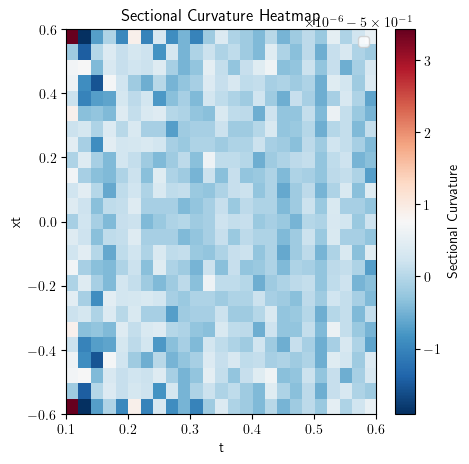

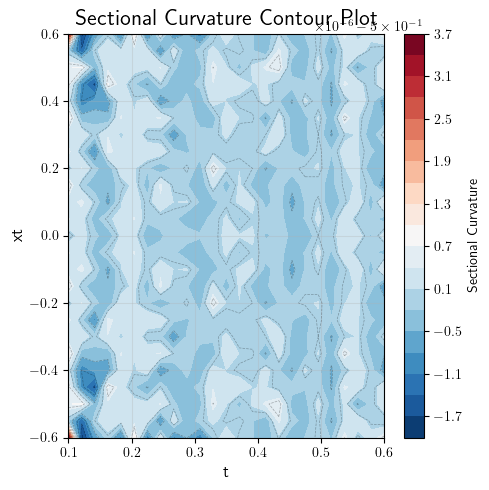


Heatmap computed with:
- t range: 0.1 to 0.6 (25 points)
- xt range: -0.6 to 0.6 (25 points)
- Curvature range: -0.5000 to -0.5000


In [ ]:
t_range = np.linspace(0.1, 0.6,25)  
xt_range = np.linspace(-0.6, 0.6, 25)    
T, XT = np.meshgrid(t_range, xt_range)

curvature_values = np.zeros_like(T)

for i, t in enumerate(t_range):
    for j, xt in enumerate(xt_range):
        tensor_input = torch.tensor([[t, xt]], dtype=torch.float32)
        curvature = compute_sectional_curvature(tensor_input)
        if torch.is_tensor(curvature):
            curvature_values[j, i] = curvature.item()
        else:
            curvature_values[j, i] = curvature
        
        if curvature_values[j, i] > 20:
            curvature_values[j, i] = 20

        if curvature_values[j, i] < -20:
            curvature_values[j, i] = -20

        print(f'sectional curvature at t={t:.2f}, xt={xt:.2f}: {curvature_values[j, i]:.4f}')

plt.figure(figsize=(5, 5))
plt.imshow(curvature_values, extent=[t_range.min(), t_range.max(), xt_range.min(), xt_range.max()],
           origin='lower', aspect='auto', cmap='RdBu_r')

plt.colorbar(label='Sectional Curvature')
plt.title('Sectional Curvature Heatmap')
plt.xlabel('t')
plt.ylabel('xt')
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
contour = plt.contourf(T, XT, curvature_values, levels=20, cmap='RdBu_r')
plt.colorbar(contour, label='Sectional Curvature')
plt.contour(T, XT, curvature_values, levels=10, colors='black', alpha=0.3, linewidths=0.5)
plt.title('Sectional Curvature Contour Plot', fontsize=16, fontweight='bold')
plt.xlabel('t', fontsize=12)
plt.ylabel('xt', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHeatmap computed with:")
print(f"- t range: {t_range.min():.1f} to {t_range.max():.1f} ({len(t_range)} points)")
print(f"- xt range: {xt_range.min():.1f} to {xt_range.max():.1f} ({len(xt_range)} points)")
print(f"- Curvature range: {curvature_values.min():.4f} to {curvature_values.max():.4f}")

Other example of curvature

sectional curvature at t=0.10, xt=-0.70: -1.2998
sectional curvature at t=0.10, xt=-0.60: -0.1206
sectional curvature at t=0.10, xt=-0.50: -0.0264
sectional curvature at t=0.10, xt=-0.40: -0.0881
sectional curvature at t=0.10, xt=-0.30: -0.9432
sectional curvature at t=0.10, xt=-0.20: -4.8518
sectional curvature at t=0.10, xt=-0.10: -2.0417
sectional curvature at t=0.10, xt=0.00: -0.7667
sectional curvature at t=0.10, xt=0.10: -2.0417
sectional curvature at t=0.10, xt=0.20: -4.8518
sectional curvature at t=0.10, xt=0.30: -0.9432
sectional curvature at t=0.10, xt=0.40: -0.0881
sectional curvature at t=0.10, xt=0.50: -0.0264
sectional curvature at t=0.10, xt=0.60: -0.1206
sectional curvature at t=0.10, xt=0.70: -1.2998
sectional curvature at t=0.15, xt=-0.70: -0.1160
sectional curvature at t=0.15, xt=-0.60: -0.0396
sectional curvature at t=0.15, xt=-0.50: -0.0232
sectional curvature at t=0.15, xt=-0.40: -0.0335
sectional curvature at t=0.15, xt=-0.30: -0.1075
sectional curvature at t=0.1

C:\Users\maria\AppData\Local\Temp\ipykernel_24916\558914985.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


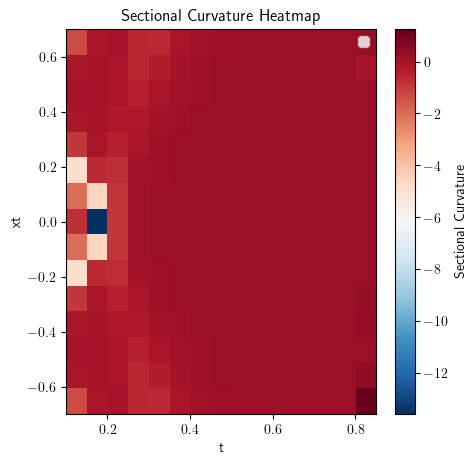

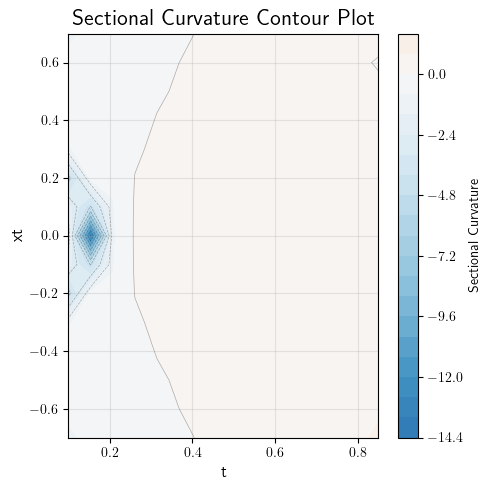


Heatmap computed with:
- t range: 0.1 to 0.8 (15 points)
- xt range: -0.7 to 0.7 (15 points)
- Curvature range: -13.6020 to 1.2539


In [23]:
'''
---------------------
Choose noise schedule
---------------------
'''

def alpha_sigma(t, s=0.008):
    """
    Cosine noise schedule from 'Improved Denoising Diffusion Probabilistic Models'.

    Args:
        t: torch.Tensor with values in [0, 1]
        s: small offset to avoid singularities (default 0.008)

    Returns:
        alpha_t, sigma_t : tensors of same shape as t
    """
    t = torch.clamp(t, 0.0, 1.0)

    # f(t) = cos^2(((t + s)/(1 + s)) * pi/2)
    f_t = torch.cos(((t + s) / (1 + s)) * math.pi / 2) ** 2

    # use math.cos or a tensor constant to avoid the float→tensor error
    f_0 = math.cos((s / (1 + s)) * math.pi / 2) ** 2

    alpha_t_sq = f_t / f_0
    alpha_t = torch.sqrt(alpha_t_sq)
    sigma_t = torch.sqrt(1.0 - alpha_t_sq)

    return alpha_t, sigma_t


'''
---------------
Hyperparameters
---------------
'''

original_means = torch.tensor([-1,0,1], dtype=torch.float32) #0,0,0   #-1,1,0
original_variance = torch.tensor(0.01, dtype=torch.float32) #0.4
weights = torch.tensor([1/3,1/3,1/3], dtype=torch.float32)


t_range = np.linspace(0.1, 0.85,15)  
xt_range = np.linspace(-0.7, 0.7, 15)    
T, XT = np.meshgrid(t_range, xt_range)

curvature_values = np.zeros_like(T)

for i, t in enumerate(t_range):
    for j, xt in enumerate(xt_range):
        tensor_input = torch.tensor([[t, xt]], dtype=torch.float32)
        curvature = compute_sectional_curvature(tensor_input)
        if torch.is_tensor(curvature):
            curvature_values[j, i] = curvature.item()
        else:
            curvature_values[j, i] = curvature
        
        if curvature_values[j, i] > 20:
            curvature_values[j, i] = 20

        if curvature_values[j, i] < -20:
            curvature_values[j, i] = -20

        print(f'sectional curvature at t={t:.2f}, xt={xt:.2f}: {curvature_values[j, i]:.4f}')


plt.figure(figsize=(5, 5))
plt.imshow(curvature_values, extent=[t_range.min(), t_range.max(), xt_range.min(), xt_range.max()],
           origin='lower', aspect='auto', cmap='RdBu_r')

plt.colorbar(label='Sectional Curvature')
plt.title('Sectional Curvature Heatmap')
plt.xlabel('t')
plt.ylabel('xt')
plt.legend()
plt.show()

plt.figure(figsize=(5, 5))
contour = plt.contourf(T, XT, curvature_values, levels=20,vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar(contour, label='Sectional Curvature')
plt.contour(T, XT, curvature_values, levels=10, colors='black', alpha=0.3, linewidths=0.5)
plt.title('Sectional Curvature Contour Plot', fontsize=16, fontweight='bold')
plt.xlabel('t', fontsize=12)
plt.ylabel('xt', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nHeatmap computed with:")
print(f"- t range: {t_range.min():.1f} to {t_range.max():.1f} ({len(t_range)} points)")
print(f"- xt range: {xt_range.min():.1f} to {xt_range.max():.1f} ({len(xt_range)} points)")
print(f"- Curvature range: {curvature_values.min():.4f} to {curvature_values.max():.4f}")

Simulate SDE: Main changes: compute_vector_field_sde, sample_sde

theta1 tensor([0.9900, 0.0000])
theta2 tensor([0.1000, 1.0763])
theta1 tensor([0.9900, 0.0000])
theta2 tensor([0.1000, 1.2181])
theta1 tensor([0.9900, 0.0000])
theta2 tensor([ 0.1000, -0.8064])
theta1 tensor([0.9900, 0.0000])
theta2 tensor([ 0.1000, -0.1744])
theta1 tensor([0.9900, 0.0000])
theta2 tensor([0.1000, 0.9146])


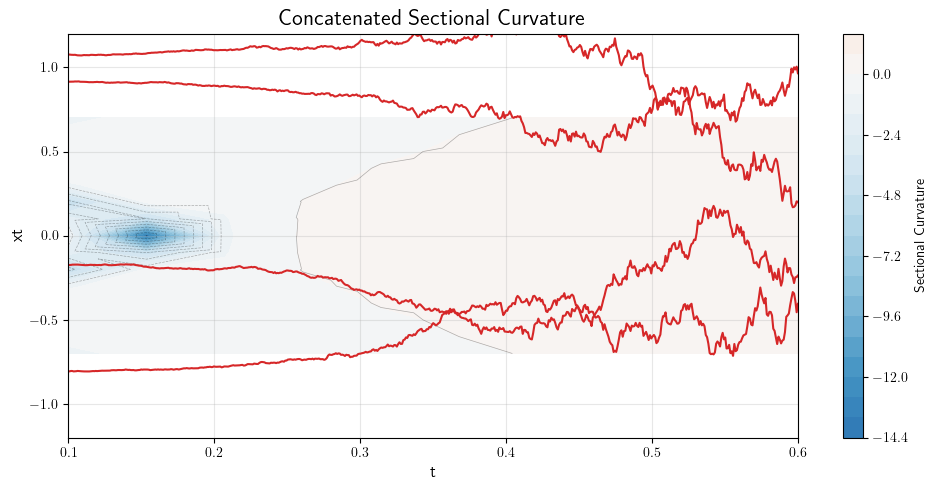

In [26]:
'''
---------------------
Choose noise schedule
---------------------
'''

def log_SNR(t):
    """Implementation of the linear-logSNR noise schedule"""
    return LAMBDA_MAX + (LAMBDA_MIN - LAMBDA_MAX) * t


def alpha_sigma(t):
    lambda_t = log_SNR(t)
    alpha_t = torch.sigmoid(lambda_t).sqrt()
    sigma_t = torch.sigmoid(-lambda_t).sqrt()
    return alpha_t, sigma_t


def compute_vector_field_sde(x, t):
    """
    PF-ODE vector field for any alpha_sigma(t)
    """
    x = x.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)

    alpha_t, sigma_t = alpha_sigma(t)

    log_alpha = torch.log(alpha_t)
    f_t = torch.autograd.grad(log_alpha.sum(), t, create_graph=True)[0]

    lambda_t = torch.log(alpha_t**2 / sigma_t**2)
    dlambda_dt = torch.autograd.grad(lambda_t.sum(), t, create_graph=True)[0]
    g2_t = - sigma_t**2 * dlambda_dt
    g_t = torch.sqrt(g2_t.clamp(min=1e-12))  # ensure positivity for noise

    log_p_t = gaussian_mixture_density(x, t)
    grad_log_p_t = torch.autograd.grad(log_p_t.sum(), x, create_graph=True)[0]

    dx = f_t * x - 0.5 * g2_t * grad_log_p_t
    dt = -torch.ones_like(dx)

    dx = dx.view(-1)
    dt = dt.view(-1)
    return dt.detach().cpu().numpy(), dx.detach().cpu().numpy(), g_t[:, None]


def sample_sde(x, n_steps, t_start=1, t_end=0.9):
    """PF-ODE sampling"""
    t = t_start * torch.ones_like(x)
    dt_val = (t_start - t_end) / n_steps
    all_x = [x.detach().numpy()]
    all_t = [t.detach().numpy()]
    for i in range(n_steps):
        dt, dx, g_t = compute_vector_field_sde(x, t)
        dW = torch.randn_like(x) * np.sqrt(abs(dt_val))
        dt, dx = torch.from_numpy(dt), torch.from_numpy(dx)
        #x = x + dt * dx * dt_val 
        x = x + dt * dx * dt_val + 0.3*g_t * dW #this factor controls the mout of noise
        t = t + dt * dt_val
        x = x.squeeze(-1)
        all_x.append(x.detach().numpy())
        all_t.append(t.detach().numpy())
    return np.array(all_t), np.array(all_x)


#Choose source nodes
x0=torch.tensor([[0.], [0.], [0.], [0.], [0.]])

fig, ax = plt.subplots(figsize=(10, 5))
x_flat = T.flatten()
y_flat = XT.flatten()
z_flat = curvature_values.flatten()

# Contour plot
contour = plt.contourf(T, XT, curvature_values, levels=20,vmin=-20, vmax=20, cmap='RdBu_r')
ax.tricontour(x_flat, y_flat, z_flat, levels=10, colors='black', alpha=0.3, linewidths=0.5)
fig.colorbar(contour, ax=ax, label='Sectional Curvature')


for i, x in enumerate(x0):
    pf_ode_sample = sample_sde(x, 1000, t_start=0.99, t_end=t_min)
    pf_ode_theta = torch.from_numpy(np.concatenate(pf_ode_sample, axis=1))
    theta1 = pf_ode_theta[0]
    theta2 = pf_ode_theta[-1]
    print('theta1', theta1)
    print('theta2', theta2)
    ax.set_ylim(-1.5,1.5)
    ax.set_xlim(0,0.6)
    ax.plot(pf_ode_theta[:, 0], pf_ode_theta[:, 1], color='C3')
    

ax.set_title('Concatenated Sectional Curvature', fontsize=16, fontweight='bold')
ax.set_xlim(0.1, 0.6)
ax.set_ylim(-1.2,1.2)
ax.set_xlabel('t', fontsize=12)
ax.set_ylabel('xt', fontsize=12)
ax.grid(True, alpha=0.3)
#ax.legend()

plt.tight_layout()
plt.show()

